## Viscolelastic Materials Example

First we Choose the model and other parameters for our data, and save this data for reference later:

In [1]:
import numpy as np
import sympy as sp
import sys
import torch

sys.path.append('../')
sys.path.append('../src')
import data.Generation.VE_DataGen_Functions as vedg
from deepymod_torch.library_function import mech_library
from deepymod_torch.DeepMod import DeepMoD
from deepymod_torch.neural_net import deepmod_init, train

In [4]:
Input_Type = 'Strain'
E = [1,1,1]
Eta = [1.25,2.5]
t = sp.symbols('t', real=True)
Input_Function = sp.exp(-t) + sp.exp(-t/10) + sp.exp(-t/20)
Input_Description = 'Three_e_Decays'
Int_Type = 'Numerical'

In [5]:
Tuple_of_Expressions = vedg.Stress_Strain_Master_Int(Input_Type, E, Eta, Input_Function, Int_Type, t)
print(Tuple_of_Expressions)

(3.0 + 3.0*exp(-0.8*t) + 3.0*exp(-0.4*t), <function Stress_Strain_Master_Int.<locals>.<lambda> at 0x152c591320>)


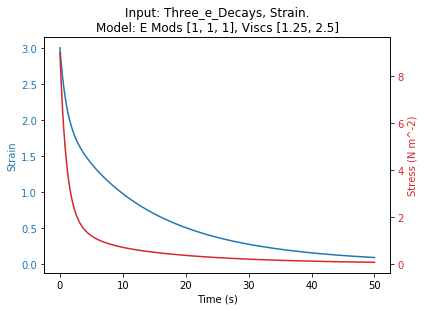

In [7]:
time = np.linspace(0.001, 50, 5000)

title = ('Input: ' + Input_Description + ', ' + Input_Type + 
         '.\nModel: E Mods ' + str(E) + ', Viscs ' + str(Eta))

Strain_Array, Stress_Array = vedg.Eval_Graph_Strain_Stress(title, time, Input_Function, Tuple_of_Expressions, Input_Type, Int_Type, t)

In [8]:
vedg.save_stress_strain(time, Strain_Array, Stress_Array, '../data/StressStrain', Input_Type, Input_Description, E, Eta)

We mostly use DeepMoD using default settings as we would for any other problems. the configuratiosn specific to this application come from knowledge we already have, namely:

- We are going to use a customised $\Theta$ that only ever computes the derivatives of stress and strain, never the squares, as we are looking solve a system where these are the only terms present. We are looking at a hybrid problem here where we aren't completely blindly exploring the system. We assume the data is stress/strain data and we assume our models for these materials are accurate so as to produce an accurate format for the equations describing their dynamic behaviour.

- For this, we need to use a library function of a new design.

- In this library function, we will ask PyTorch to compute derivatives for the output variable up to a couple of orders of differentiation beyond expectations, just to demonstrate teh DeepmoD both, finds the correct coefficients, but also removes terms that should not be present.

- the library function will also contain the assumption that all coefficients on the input function are negative. this way, teh coefficients that DeepMoD shoudl find will all be positive, as all viscosties and elastic moduli are postive, so all sums and products of them are also, and this si what makes up the coefficient.

- This will allow us to further tinker and ask the random initial values of teh coefficients to all be positive, getting round an issue with DeepMod getting stuck in local minima

- The derivatives of teh input function can be calculated without the neural network, as teh functional form of this is know. These results are still built into the loss though, as part of the equation-regression term.

- Additionalyl, the lambda paramter will be made small. in essence, we are not looking for a very sparse vector, so L1 regullarisation actually hinders the convergence process.

- Additionally, the LHS of the equation is fixed to the time derivative of the input with coeff 1

> Is it the time derivative of the input, or always strain!!!!!!

Once DeepMoD has its coefficnets, the job is not done as the coefficients need to be traced back into E_Mods and Viscs. i am not yet sure how to do this but

- there will be two stages. the first is developing teh expressions for coeff 1 is this combination, coeff 2 is that one etc, and then teh second stage is using these simultaneous expressions to instead right each paramter in terms of teh coeffs.

- The first part is not trivial as the parameters that go into forming the coeffs will be different depending on how many parameters are genuinely present in the model. The number of derivatives that deepmod finds can be used to determine which set of equations are going to be used.

- Either these equations can be hard coded or

- A pattern can be identified so that once the number of parameters is known, a loop can be run to generate the expressions (However, this method is only weakly scalable as, although identifying a pattern would allow easy identification of the full description of the coeffs for low order derivatives, the patterns would need to be worked out by hand for even higher derivatives leaving a) a lot of work by hand to allow the analysis to handle, let's say, 12th order derivatives and b) there will always be a ceiling determined arbitrarily by how high I have worked out the expressions for.) or

- The root equation with sum could be looped and written in sympy, and the rearranged and sympy could be asked to find the expressions for coeffs of each term. the function `Differential` rather than `.diff` will be useful here to maintain the unsolved derivatives. Side note for coding: probably symbols can be placed into lists so that they do not have to be given unique names which could be tricky in a loop. -> ie `List_Syms[3] = sym.symbols('Tau'+Loop_Number, real=True)` etc.

- The coeff on the LHS of the equation being fixed to 1 fixes all the other coeffs, so there is no ambiguity here.

For the second part, using the coeffs to calculate each model parameter

- I am hoping i can just use some function called solve or something in sympy to get the expressions for each aparamter in term so the coeffs, once the part 1 above is done. Indeed, this is possible on mathematica as demonstrated by the screenshot Remy sent by email.

- Alternatively, they could be hard coded in if worked them out by hand......

Extra idea: The order of derivative should be teh same in both stress and strain. This is not a wild assumption. Perhaps teh loss can be further modified so as to penilise a situation where higher derivatives are being allowed in the 1st half of coeffs vs the other.

Extra Idea: If the third derivative has been identified as being zero, all higher derivatives must also be zero. Remy suggested not harshly setting all to zero immediately, but removing the highest derivative and retraining, and then repeating, to see if lower derivatives are recovered.

There is another consideration. There are two ways we can get the optimisation procedure to discover the right equation. The 'One Big Step' approach means modifying the loss function to be more and more aggressive. The other is a more iterative approach where the result can be critiqued, something changed, and the optimisation run again, such as the removal of the highest derivative.

Extra note: need to think about the GKM vs GMM stuff. Essentially, teh creep and relaxation expressions used to generate the data have come from a GKM, not a GMM!. Presumably the results may differ slightly with a GMM, but at the same time, this leads to a direct final result, and the result should be the same if the two models are genuinely equivalent???

In any case, the coefficents worked out will be different depending on whether we analyse in terms of a GKM or GMM. At leats at first glnce, would be an interesting test. certainly, the set of parameters making up each deduced coeff would be different, but perhaps, once the simultaneous equations are solved the resulting paramters are the same. ie, the coeff for the second deriv of stress will be described by different parameters sepending on the model, but a) the value for this coeff is model independant and b) the paremeters are model independant, its just that a different set of these parameters can be combined in a different way to get the same coeff.

## Actually getting on with it

We next need to reshape the data into a conveneint form. `vedg.save_stress_strain` does this also, so if importing the data this next step is unnecessary.

For the purpose of running deepmod, we do not need the calculated dat for whatever the input is, as we will instead provide teh analytical expression. Understanding this is important as it explains why for around half of the terms in theta, we don't need to use the result of the NN to obtain the values, we can easily obtain them directly from the anayltical expression

In [5]:
time_Array = time.reshape(-1, 1)
Stress_Array = Stress_Array.reshape(-1, 1)

or

In [10]:
data = np.loadtxt('../data/StressStrain/Strain Three_e_Decays E[1, 1, 1] V[1.25, 2.5].csv', delimiter=',')
time_Array = data[:,[0]] # submitting the column index as a list preserves the idea that time_Array is a column,
                            #otherwise it would default to a 1D array.
Stress_Array = data[:,[2]]

This is now the point where we might add **noise** and perform **random sampling** of the data. For now, in this first version of the notebook, we will skip this step.

So, to fully prepare the data for injection into PyTorch, we need to convert the arrays into tensors:

In [11]:
import torch

In [12]:
time_Tensor = torch.tensor(time_Array, dtype=torch.float32, requires_grad=True)
Stress_Tensor = torch.tensor(Stress_Array, dtype=torch.float32)#, requires_grad=True)

### Preparing the NN

Begin by setting up DeepMoD as normal, as per Burgers example and then I will interogate for changes

`optim_config` is contains only a minor change. I have reduced the lambda variable to deemphasise the need for a sparse coeff_vector. I may do further tweaks later.

`network config` contains the important change that there is only 1 input dimension in our problem, ie, only $t$. I have also reduced the size of the NN rather arbitrarily.

In [13]:
optim_config = {'lambda': 10**-6, 'max_iterations': 20000}
network_config = {'input_dim': 1, 'hidden_dim': 15, 'layers': 3, 'output_dim': 1}

The changes to `lib_config` is the business end. Poly order is a redundant variable as the single 'polynomial' term which would be stress or strain to the power of one, can be accounted for as the zeroth order derivative. There is no constant. An entirely new library 'type' function is created for our problem.

Additionally, three new configuration paramters for our library dictionary are created. The first is the additional entry that will enforce the idea that all the initial guesses at the value of the coeffs (ksi vector) must be positive. The latter two allow the library to put the coefficients in the same order regardless of whether strain or stress was described by an analytical expression of our design, the analytical expression also being given as the final item in the dictionary.

In [14]:
from deepymod_torch.library_function import mech_library

In [15]:
lib_config = {'type': mech_library, 'diff_order': 3, 'coeff_sign': 'positive', 'input_type': Input_Type, 'input_expr': Input_Function}

With these configurations, in theory we should be able to run deepmod to interrogate the values of the coefficients of the derivatives in the general expression.

Except, to break it down a little for this first run, let's actually pull out the code from DeepMoD and run bits step by step to better check for errors.

First, we initialise the NN.

In [16]:
from deepymod_torch.neural_net import deepmod_init

In [17]:
network, coeff_vector_list, sparsity_mask_list = deepmod_init(network_config, lib_config)

New theta_from_input!


In [18]:
network

Sequential(
  (0): Linear(in_features=1, out_features=15, bias=True)
  (1): Tanh()
  (2): Linear(in_features=15, out_features=15, bias=True)
  (3): Tanh()
  (4): Linear(in_features=15, out_features=15, bias=True)
  (5): Tanh()
  (6): Linear(in_features=15, out_features=15, bias=True)
  (7): Tanh()
  (8): Linear(in_features=15, out_features=1, bias=True)
)

due to some changes made in the neural_net.py file, we notice the following has managed to take on board the need for these starting values to be positive.

In [19]:
coeff_vector_list

[tensor([[0.9892],
         [1.3054],
         [0.5081],
         [0.4842],
         [0.0099],
         [0.9991],
         [0.8547]], requires_grad=True)]

In [20]:
sparsity_mask_list

[tensor([0, 1, 2, 3, 4, 5, 6])]

Now that we have our network and starting coeffs, let's try and train the network. This is the part one trainign which still includes the L1 term and contains all terms. As I specified a diff order of 5 earlier, this may be a little long to process....

In [21]:
from deepymod_torch.neural_net import train

In [22]:
time_deriv_list, theta, coeff_vector_list = train(time_Tensor, Stress_Tensor, network, coeff_vector_list, 
                                                  sparsity_mask_list, lib_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
New theta_from_input!
0 1.4E+00 1.4E+00 0.0E+00 0.0E+00
tensor([[0.9892],
        [1.3054],
        [0.5081],
        [0.4842],
        [0.0099],
        [0.9991],
        [0.8547]], requires_grad=True)
500 3.4E-01 3.4E-01 0.0E+00 0.0E+00
tensor([[0.9892],
        [1.3054],
        [0.5081],
        [0.4842],
        [0.0099],
        [0.9991],
        [0.8547]], requires_grad=True)
1000 1.4E-01 1.4E-01 0.0E+00 0.0E+00
tensor([[0.9892],
        [1.3054],
        [0.5081],
        [0.4842],
        [0.0099],
        [0.9991],
        [0.8547]], requires_grad=True)
1500 6.5E-02 6.5E-02 0.0E+00 0.0E+00
tensor([[0.9892],
        [1.3054],
        [0.5081],
        [0.4842],
        [0.0099],
        [0.9991],
        [0.8547]], requires_grad=True)
2000 3.2E-02 3.2E-02 0.0E+00 0.0E+00
tensor([[0.9892],
        [1.3054],
        [0.5081],
        [0.4842],
        [0.0099],
        [0.9991],
        [0.8547]], requires_grad=True)
2500 1.7E-02 1.7E-02 0.0E+

In [15]:
from deepymod_torch.DeepMod import DeepMoD

In [16]:
#sparse_coeff_vector, sparsity_mask, network = DeepMoD(time_Tensor, Stress_Tensor, network_config, lib_config, optim_config)